# Linking Multiple Chains Sequentially with LCEL
* Notebook by Adam Lang
* Date: 10/23/24

# Overview
* In this notebook we will demonstrate how to link multiple chains sequentially in LangChain using LCEL syntax.
* The use case we will use is a customer service chatbot.
  * Input 1 will be the customer ticket in their source language
  * Input 2 will be chaining this to translate the ticket from the users source language to answer the question.
  * Input 3 will be chaining the response and translating it back to the original language.

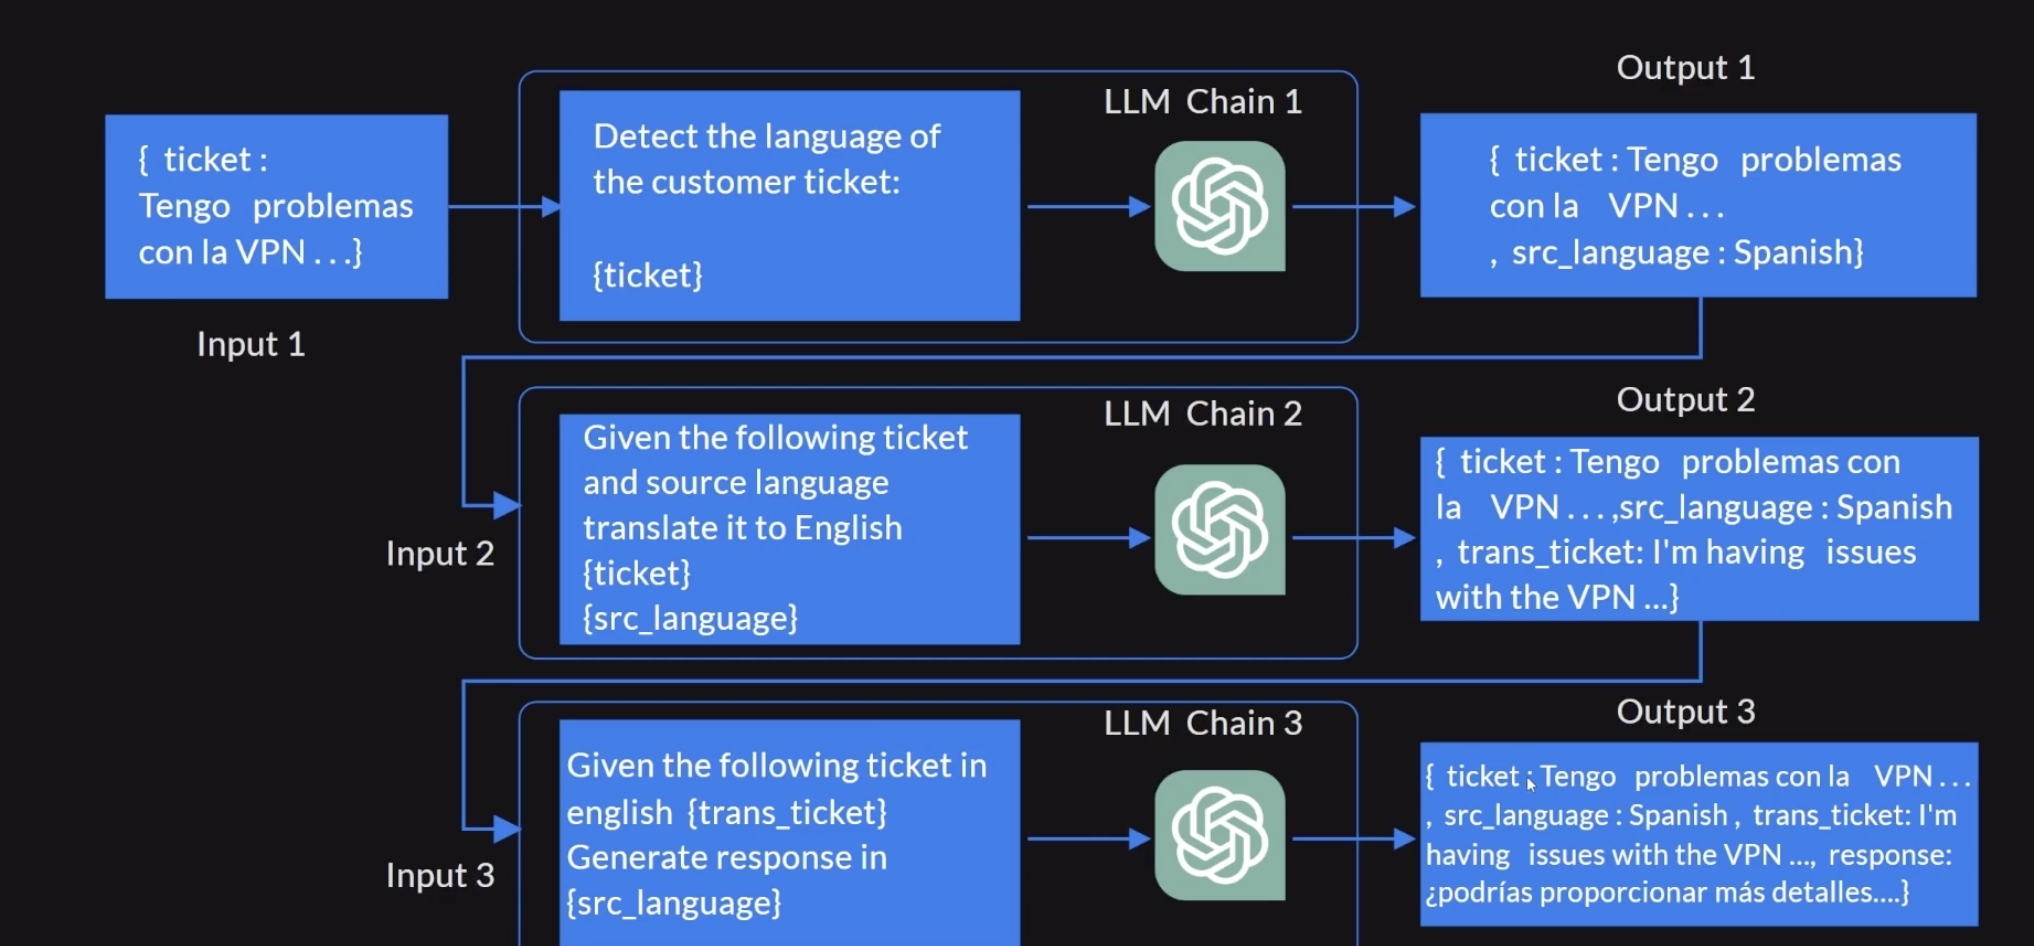



# Linking, Branching, Merging, Routing and Moderating Chains with LCEL

## Install dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 902.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Enter Open AI API key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API key: ')

Enter Open AI API key: ··········


## Setup Environment Variables

In [3]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Load LLM Connection
* Create connection to an LLM here we will use ChatGPT but you can choose any LLM you like.

In [4]:
from langchain_openai import ChatOpenAI

## init LLM of choice
chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)


# Linking Multiple Chains Sequentially in LCEL
* Here we will see how we can link several LLM chains sequentially using LCEL.
* Typically the output from one chain might go as input into the next chain and so on.
* The overall chain would run each chain sequentially in order until we get the final output which can be a combination of intermediate outputs and inputs from previous chains.

In [5]:
it_support_queue = [
    "I can't access my email. It keeps showing an error message. Please help.",
    "Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?",
    "Mon imprimante ne répond pas et n'imprime plus. J'ai besoin d'aide pour la réparer.",
    "我无法访问公司的网站。每次都显示错误信息。请帮忙解决。"
]

it_support_queue

["I can't access my email. It keeps showing an error message. Please help.",
 'Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?',
 "Mon imprimante ne répond pas et n'imprime plus. J'ai besoin d'aide pour la réparer.",
 '我无法访问公司的网站。每次都显示错误信息。请帮忙解决。']

Create our first LLM chain

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Chain 1: Detect customer message language
prompt1 = """
  Act as a customer support agent.
  For the customer support message delimited below by triple backticks,
  Output the language of the message in one word only, e.g. Spanish

  Customer Message:
  ```{orig_msg}```
  """

prompt_template1 = ChatPromptTemplate.from_template(prompt1)
## chain 1
llm_chain1 = (prompt_template1
                    |
              chatgpt
                    |
              StrOutputParser()

              )

In [7]:
## index an output
it_support_queue[1]

'Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?'

In [8]:
## invoke chain 1
llm_chain1.invoke({'orig_msg': it_support_queue[1]})

'Spanish'

We now need to link the chains using `RunnablePassthrough`

In [10]:
from langchain.schema.runnable import RunnablePassthrough

## init runnablepassthrough
RunnablePassthrough.assign(orig_lang=llm_chain1).invoke({'orig_msg': it_support_queue[1]})


{'orig_msg': 'Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?',
 'orig_lang': 'Spanish'}

Create 2nd LLM Chain

In [11]:
## Chain 2: Translate Customer Message to English
prompt2 = """
  Act as a customer support agent.
  For the customer message and customer message language delimited below by triple backticks,
  Translate the customer message from the customer message language to English
  if customer message language is not in English,
  else return back the original customer message.

  Customer Message:
  ```{orig_msg}```
  Customer Message Language:
  ```{orig_lang}```
"""
prompt_template2 = ChatPromptTemplate.from_template(prompt2)
## chain 2
llm_chain2 = (prompt_template2
                    |
              chatgpt
                    |
              StrOutputParser())

Create 3rd LLM Chain

In [12]:
## Chain 3: Generate a resolution response in English
prompt3 = """
  Act as a customer support agent.
  For the customer support message delimited below by triple backticks,
  Generate an appropriate resolution response in English.

  Customer Message:
  ```{trans_msg}```
"""
prompt_template3 = ChatPromptTemplate.from_template(prompt3)
## chain 3
llm_chain3 = (prompt_template3
                    |
              chatgpt
                    |
              StrOutputParser())


Create 4th LLM Chain

In [13]:
# Chain 4: Translate resolution response from English to Customer's language
prompt4 = """
  Act as a customer support agent.
  For the customer resolution response and target language delimited below by triple backticks,
  Translate the customer resolution response message from English to the target language
  if target language is not in English,
  else return back the original customer resolution response.

  Customer Resolution Response:
  ```{trans_response}```
  Target Language:
  ```{orig_lang}```
"""
prompt_template4 = ChatPromptTemplate.from_template(prompt4)
## chain 4
llm_chain4 = (prompt_template4
                    |
              chatgpt
                    |
              StrOutputParser())



Summary:
* We now have 3 separate LLM chains and we can now link them.

### Linking the 4 chains together

In [14]:
from langchain.schema.runnable import RunnablePassthrough

## final linked chain
final_chain = (
    RunnablePassthrough.assign(orig_lang=llm_chain1)
      |
    RunnablePassthrough.assign(trans_msg=llm_chain2)
      |
    RunnablePassthrough.assign(trans_response=llm_chain3)
      |
    RunnablePassthrough.assign(orig_response=llm_chain4)
)

In [15]:
{'orig_msg': it_support_queue[1]}

{'orig_msg': 'Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?'}

In [16]:
## pass 1 message now to final chain
response = final_chain.invoke({'orig_msg': it_support_queue[1]})
response

{'orig_msg': 'Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?',
 'orig_lang': 'Spanish',
 'trans_msg': "I'm having issues with the VPN. I can't connect to the company's network. Can you help me, please?",
 'trans_response': "Resolution Response:\nI'm sorry to hear that you're experiencing issues with the VPN. To assist you further, could you please provide more details about the error message you're receiving or any specific steps you've already taken to troubleshoot the problem? This will help us better understand the issue and provide you with the appropriate solution. Thank you for your cooperation.",
 'orig_response': 'Respuesta de resolución:\nLamento escuchar que estás experimentando problemas con la VPN. Para ayudarte mejor, ¿podrías proporcionar más detalles sobre el mensaje de error que estás recibiendo o los pasos específicos que ya has tomado para solucionar el problema? Esto nos ayudará a comprender mejor el problema y br

In [17]:
## lets see the original it support queue
it_support_queue

["I can't access my email. It keeps showing an error message. Please help.",
 'Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?',
 "Mon imprimante ne répond pas et n'imprime plus. J'ai besoin d'aide pour la réparer.",
 '我无法访问公司的网站。每次都显示错误信息。请帮忙解决。']

In [18]:
## lets format this
it_support_queue_formatted = [{'orig_msg': msg} for msg in it_support_queue]
it_support_queue_formatted

[{'orig_msg': "I can't access my email. It keeps showing an error message. Please help."},
 {'orig_msg': 'Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?'},
 {'orig_msg': "Mon imprimante ne répond pas et n'imprime plus. J'ai besoin d'aide pour la réparer."},
 {'orig_msg': '我无法访问公司的网站。每次都显示错误信息。请帮忙解决。'}]

In [19]:
## now map final chain to questions with responses
responses = final_chain.map().invoke(it_support_queue_formatted)

In [20]:
## create a pandas df to view this
import pandas as pd
pd.DataFrame(responses)


,orig_msg,orig_lang,trans_msg,trans_response,orig_response
0,I can't access my email. It keeps showing an e...,English,I can't access my email. It keeps showing an e...,Resolution:\nI apologize for the inconvenience...,Resolution:\nI apologize for the inconvenience...
1,Tengo problemas con la VPN. No puedo conectarm...,Spanish,I am having issues with the VPN. I cannot conn...,Resolution:\nI'm sorry to hear that you're exp...,Resolución:\nLamento escuchar que estás experi...
2,Mon imprimante ne répond pas et n'imprime plus...,French,My printer is not responding and not printing ...,Resolution:\nI'm sorry to hear that you're exp...,Résolution:\nJe suis désolé d'apprendre que vo...
3,我无法访问公司的网站。每次都显示错误信息。请帮忙解决。,Chinese,I cannot access the company's website. An erro...,Resolution:\nI apologize for the inconvenience...,```Resolution:\n对于您正在经历的不便，我感到抱歉。为了更好地帮助您，您能否提...
